# Get ICESat-2 Data 
#### Based on the Tutorial by Amy Steiker at ICESat-2 Hackweek, June 2019
Modified by Kristin Poinar on Tuesday June 18 for #WaterNoice project


In [58]:
# Give path of polygon that outlines the area of interest for data download
kml_filepath = str('../kmlfiles/seeps-koge.kml')
kml_filepath = str('../kmlfiles/seeps.kml')

# Give data set ID (e.g. ATL06) here, also known as "short name"
short_name = 'ATL06'
short_name = 'ATL03'



# Input start date in yyyy-MM-dd format
start_date = '2018-10-22'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-02-22'
# Input end time in HH:mm:ss format
end_time = '23:59:59'



# Where to put the data?
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/SeepOutputs_' + kml_filepath[12:-4] + '_' + short_name)
print(path)
# if not os.path.exists(path):
#     os.mkdir(path)

# Earthdata Login credentials
# Enter your Earthdata Login user name
uid = 'kristinpoinar'
# Enter your email address associated with your Earthdata Login account
email = 'kpoinar@buffalo.edu'
pswd = getpass.getpass('Earthdata Login password: ')

/home/jovyan/WaterNoice/notebooks/SeepOutputs_seeps_ATL03


Earthdata Login password:  ············


## Import packages


In [59]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import h5py
import re
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

## Create a token

#### We will generate a token needed in order to access data using your Earthdata Login credentials, and we will apply that token to the following queries. If you do not already have an Earthdata Login account, go to http://urs.earthdata.nasa.gov to register. Your password will be prompted for privacy.

In [60]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
#print(token)

## Determine the number and size of granules available within a time range and location.

#### Let's explore information about our data set. We'll start by determining the most recent version number of our data set. We will also find out how many data granules (files) exist over an area and time of interest. [The Common Metadata Repository](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation") is queried to explore this information. 

In [61]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
#pprint.pprint(results)

# There may be cases where more than one data set version exists, which may happen when ICESat-2 data 
# version updates. Let's make sure we have the most recent version of our data set.

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
#print(latest_version)

# Parse temporal range 
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2018-10-22T00:00:00Z,2019-02-22T23:59:59Z


### Area of Interest input

I'll be using Option 3, Spatial file input, including Esri Shapefile or KML/KMZ. 
Use geopandas to read in the file.

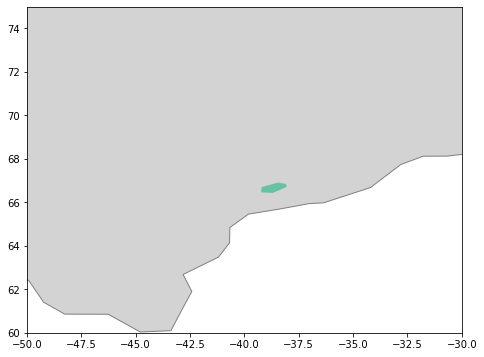

In [62]:
# Use geopandas to read in polygon file
# Note: a shapefile or geojson, or almost any other vector-based spatial data format could be substituted here.

# kml_filepath = str('../kmlfiles/seeps-koge.kml')
# kml_filepath = str('../kmlfiles/seeps.kml')

#Return a GeoDataFrame object
gdf = gpd.read_file(kml_filepath)
gdf.head()

# And visualize it
%matplotlib inline

# Load "Natural Earth” countries dataset, bundled with GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Overlay glacier outline
f, ax = plt.subplots(1, figsize=(12, 6))
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
gdf.plot(ax=ax, cmap='Set2')
ax.set_ylim([60, 75])
ax.set_xlim([-50,-30]);

# Simplify and reorder the GeoDataFrame object using the shapely package 
# and convert the object back to a dictionary to be applied to the CMR polygon parameter. 
# Simplification is needed in order to pass a reasonable request length to CMR. 
# You may need to modify the simplification tolerance depending on the number of points of your polygon.

#Integer position based indexing of GeoDataFrame object to get it into a shapeply geometry object.
poly = gdf.iloc[0].geometry

# Simplify polygon. The larger the tolerance value, the more simplified the polygon.
#poly = poly.simplify(0, preserve_topology=False)

# Orient counter-clockwise
poly = orient(poly, sign=1.0)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# aoi value used for CMR params below
aoi = '3'

#### We will now populate dictionaries to be applied to our search query below based on spatial and temporal inputs. For additional search parameters, see the [The Common Metadata Repository API documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation").


In [63]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

#print('CMR search parameters: ', params)



# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)

granule_sizes = [float(granule['granule_size']) for granule in granules]

# Average size of granules in MB
mean(granule_sizes)

# Total volume in MB
sum(granule_sizes)

20209.744346619

## Select the subsetting and reformatting services enabled for your data set of interest.
The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Reformatting and subsetting are available on all Level-2 and -3 ICESat-2 data sets. Let's discover the specific service options supported for this data set and select which of these services we want to request. 

We will start by querying the service capability to gather and select customization options.

In [64]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

#print(capability_url)

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)


# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]


# Let's confirm that subset services exist for our data set by reviewing the `subagent` list. 
# If the list contains service information, we know that services are available. If not, we need to 
# set the `agent` API parameter to `NO` to indicate that our request will bypass the subsetter. 
# This will quickly send back the data "natively" without any customization applied.
print(subagent)
if len(subagent) < 1 :
    agent = 'NO'

[{'id': 'ICESAT2', 'spatialSubsetting': 'true', 'spatialSubsettingShapefile': 'true', 'temporalSubsetting': 'true', 'type': 'both', 'maxGransSyncRequest': '100', 'maxGransAsyncRequest': '2000'}]


### We'll begin populating the subsetting and reformatting parameters used for our NSIDC API request. In addition to the CMR information we queried above, the NSIDC API accepts Key-Value-Pairs (KVPs) for subsetting and reformatting services.

#### Let's start with spatial subsetting. Recall that there are three options to *filter* our search results by spatial constraint: 

1) Bounding Box: Corresponding to the CMR `bounding_box` KVP

2) Polygon coordinate pairs: Corresponding to the CMR `polygon` KVP

3) Spatial file input, including Esri Shapefile or KML/KMZ: We simplified the file input to also be read by the CMR `polygon` KVP 
    
#### We see above that `spatialSubsetting` is `true` and `spatialSubsettingShapefile` is `true`. Therefore the same *filtering* options can be applied to our *subset* constraint, with unique KVPs for the subsetting service:

1) Bounding Box: `bbox` subset KVP

2) Polygon coordinate pairs: `bounding_shape` subset KVP in [GeoJSON](https://geojson.org/) format. 

3) Spatial file input: The file can be read directly by the subsetter without simplification. This file will be posted to the API endpoint, so we don't need to specify an additional subset KVP here. 

#### Temporal subsetting is next, since we saw above that `temporalSubsetting` is `true`. We filtered data over 22 Feb 2019 and we can also subset the data to those dates if desired. 

The `time` KVP is used to subset temporally. This can be entered in the following formats:

`time=yyyy-mm-dd,yyyy-mm-dd`

`time=yyy-mm-ddThh:MM:ss,yyy-mm-ddThh:MM:ss` 

In [65]:
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time
print(timevar)

# Finally, let's determine if variable subsetting is available by finding the 
# length of the `variable_vals` list we gathered from the capabilities URL. 
len(variable_vals)


# And we can enter a list of variables to subset separated by comma using the `coverage` key. 
# All forward slashes need to be included to indicate HDF group hierarchy.

coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
/gt1l/land_ice_segments/atl06_quality_summary,\
/gt1l/land_ice_segments/delta_time,\
/gt1l/land_ice_segments/h_li,\
/gt1l/land_ice_segments/h_li_sigma,\
/gt1l/land_ice_segments/latitude,\
/gt1l/land_ice_segments/longitude,\
/gt1l/land_ice_segments/segment_id,\
/gt1l/land_ice_segments/sigma_geo_h,\
/gt1r/land_ice_segments/atl06_quality_summary,\
/gt1r/land_ice_segments/delta_time,\
/gt1r/land_ice_segments/h_li,\
/gt1r/land_ice_segments/h_li_sigma,\
/gt1r/land_ice_segments/latitude,\
/gt1r/land_ice_segments/longitude,\
/gt1r/land_ice_segments/segment_id,\
/gt1r/land_ice_segments/sigma_geo_h,\
/gt2l/land_ice_segments/atl06_quality_summary,\
/gt2l/land_ice_segments/delta_time,\
/gt2l/land_ice_segments/h_li,\
/gt2l/land_ice_segments/h_li_sigma,\
/gt2l/land_ice_segments/latitude,\
/gt2l/land_ice_segments/longitude,\
/gt2l/land_ice_segments/segment_id,\
/gt2l/land_ice_segments/sigma_geo_h,\
/gt2r/land_ice_segments/atl06_quality_summary,\
/gt2r/land_ice_segments/delta_time,\
/gt2r/land_ice_segments/h_li,\
/gt2r/land_ice_segments/h_li_sigma,\
/gt2r/land_ice_segments/latitude,\
/gt2r/land_ice_segments/longitude,\
/gt2r/land_ice_segments/segment_id,\
/gt2r/land_ice_segments/sigma_geo_h,\
/gt3l/land_ice_segments/atl06_quality_summary,\
/gt3l/land_ice_segments/delta_time,\
/gt3l/land_ice_segments/h_li,\
/gt3l/land_ice_segments/h_li_sigma,\
/gt3l/land_ice_segments/latitude,\
/gt3l/land_ice_segments/longitude,\
/gt3l/land_ice_segments/segment_id,\
/gt3l/land_ice_segments/sigma_geo_h,\
/gt3r/land_ice_segments/atl06_quality_summary,\
/gt3r/land_ice_segments/delta_time,\
/gt3r/land_ice_segments/h_li,\
/gt3r/land_ice_segments/h_li_sigma,\
/gt3r/land_ice_segments/latitude,\
/gt3r/land_ice_segments/longitude,\
/gt3r/land_ice_segments/segment_id,\
/gt3r/land_ice_segments/sigma_geo_h,\
/orbit_info/cycle_number,\
/orbit_info/rgt,\
/orbit_info/orbit_number' 

2018-10-22T00:00:00,2019-02-22T23:59:59


## Request data from the NSIDC data access API.

#### Let's go over the configuration parameters:

* `request_mode`
* `page_size`
* `page_num`

`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

**Use the streaming `request_mode` with caution: While it can be beneficial to stream outputs directly to your local directory, note that timeout errors can result depending on the size of the request, and your request will not be queued in the system if NSIDC is experiencing high request volume. For best performance, I recommend setting `page_size=1` to download individual outputs, which will eliminate extra time needed to zip outputs and will ensure faster processing times per request. An example streaming request loop is available at the bottom of the tutorial below. **

Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous (streaming). For now, let's select 10 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

In [66]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

# Determine how many individual orders we will request based on the number of granules requested

print(page_num)


# We'll also create a new dictionary of NSIDC API KVPs to be used in our subset request. 
# Because we are looping through each page of requests, we'll add the `page_num` KVP to our dictionary 
# within the loop below.

#Print API base URL + request parameters
API_request = f'{base_url}?short_name={short_name}&version={latest_version}&temporal={temporal}&time={timevar}&polygon={polygon}&Coverage={coverage}&request_mode={request_mode}&page_size={page_size}&page_num={page_num}&token={token}&email={email}'
#print(API_request)

subset_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'time': timevar, 
    'polygon': polygon,  
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
}
 #   'Coverage': coverage,
 #   }
#print(subset_params)

2


#### After all of these KVP inputs, what does our request look like? Here's a summary of all possible KVPs that we explored, both for CMR searching and for the subsetter:

#### CMR search keys:
* `short_name=`
* `version=`
* `temporal=`
* `bounding_box=`
* `polygon=`

#### Customization service keys:
* `time=`
* `bbox=`
* `bounding_shape=` 
* `format=`
* `projection=`
* `projection_parameters=`
* `Coverage=`

#### No customization (access only):
* `agent=`    
* `include_meta=` 
    * `Y` by default. `N` for No metadata requested.

#### Request configuration keys:
* `request_mode=` 
* `page_size=`
* `page_num=`
* `token=`
* `email=`


#### We'll request the same data but without any subsetting services applied. Let's create another request parameter dictionary with the `time` and `coverage` service keys removed, and we'll add `agent=NO` instead.

## Request Data

In [67]:
# Finally, we'll download the data directly to this notebook directory in a new Outputs folder. 
# The progress of each order will be reported.

    
# Let's run our request loop with subsetting services applied. 
# We will post the KML file directly to the API:

# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    subset_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

    shape_post = {'shapefile': open(kml_filepath, 'rb')}
    request = session.post(base_url, params=subset_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
#     request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL03&version=001&temporal=2018-10-22T00%3A00%3A00Z%2C2019-02-22T23%3A59%3A59Z&time=2018-10-22T00%3A00%3A00%2C2019-02-22T23%3A59%3A59&polygon=-38.4473901024492%2C66.9086039587665%2C-39.2106092081328%2C66.6988972341601%2C-39.231182022375%2C66.4596776379638%2C-38.6939296965283%2C66.4309364993326%2C-38.0544246374648%2C66.7145224687654%2C-38.0989491581698%2C66.8478161818577%2C-38.4473901024492%2C66.9086039587665&request_mode=async&page_size=10&token=856C8B10-6302-485D-080B-021D047A370D&email=kpoinar%40buffalo.edu&page_num=1
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:e

#### Clean up the Output folder by removing individual order folders:

In [57]:
print(path)

#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))
        
#List files
print(path)

sorted(os.listdir(path))

/home/jovyan/WaterNoice/notebooks/SeepOutputs_seeps-koge_ATL03
/home/jovyan/WaterNoice/notebooks/SeepOutputs_seeps-koge_ATL03


['processed_ATL03_20181023060445_03760105_001_01.h5',
 'processed_ATL03_20181027055627_04370105_001_01.h5',
 'processed_ATL03_20181031054809_04980105_001_01.h5',
 'processed_ATL03_20181103165500_05510103_001_01.h5',
 'processed_ATL03_20181107164645_06120103_001_01.h5',
 'processed_ATL03_20181111163828_06730103_001_01.h5',
 'processed_ATL03_20181115163006_07340103_001_01.h5',
 'processed_ATL03_20181117044918_07570105_001_01.h5',
 'processed_ATL03_20181121044053_08180105_001_01.h5',
 'processed_ATL03_20181125043226_08790105_001_01.h5',
 'processed_ATL03_20181129042405_09400105_001_01.h5',
 'processed_ATL03_20181202153054_09930103_001_01.h5',
 'processed_ATL03_20181206152234_10540103_001_01.h5',
 'processed_ATL03_20181210151415_11150103_001_01.h5',
 'processed_ATL03_20181214150555_11760103_001_01.h5',
 'processed_ATL03_20181220031651_12600105_001_01.h5',
 'processed_ATL03_20181224030832_13210105_001_01.h5',
 'processed_ATL03_20181228030013_13820105_001_01.h5',
 'processed_ATL03_2019010413